In [2]:
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from statistics import mode
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [4]:
current_dir = os.getcwd()
print("Current Directory:", current_dir)
dataset_path = os.path.join(current_dir, "../Official-Dataset/diabetic_data.csv")
print("Dataset Path:", dataset_path)


Current Directory: /workspaces/Hospital-Readmission-Prediction/scripts
Dataset Path: /workspaces/Hospital-Readmission-Prediction/scripts/../Official-Dataset/diabetic_data.csv


In [5]:
original_data = pd.read_csv(dataset_path)
original_data.shape

(101766, 50)

In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
original_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


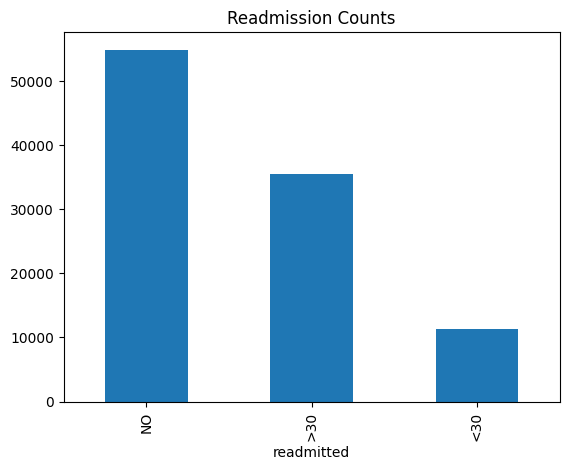

In [8]:
target_count=original_data['readmitted'].value_counts()
target_count.plot(kind='bar', title='Readmission Counts')
plt.show()

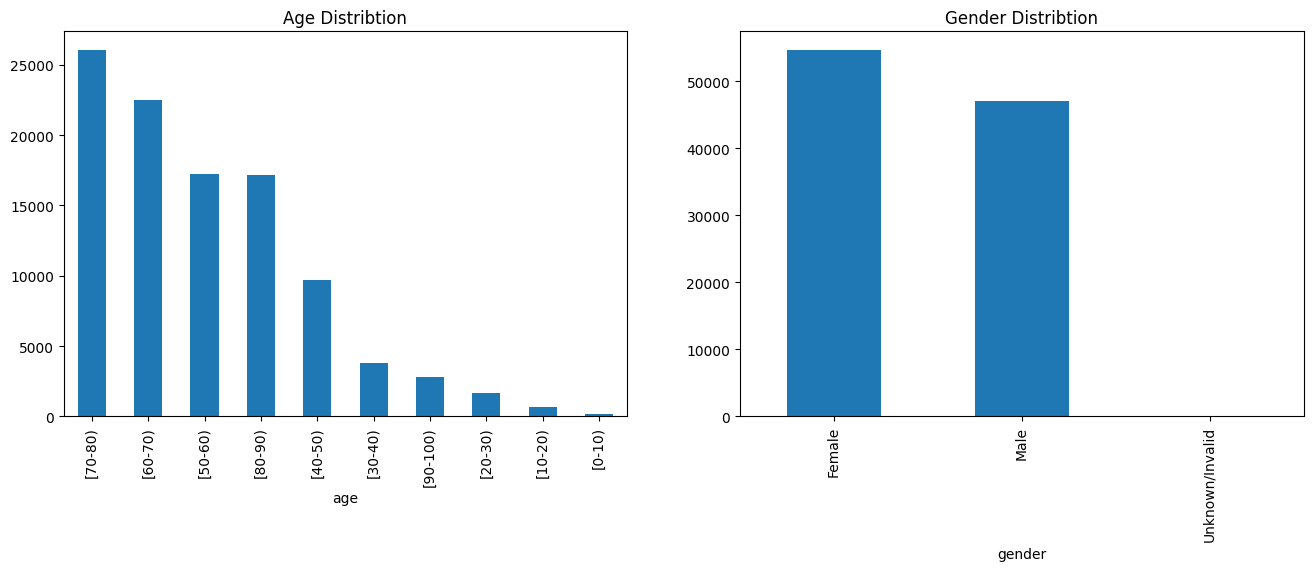

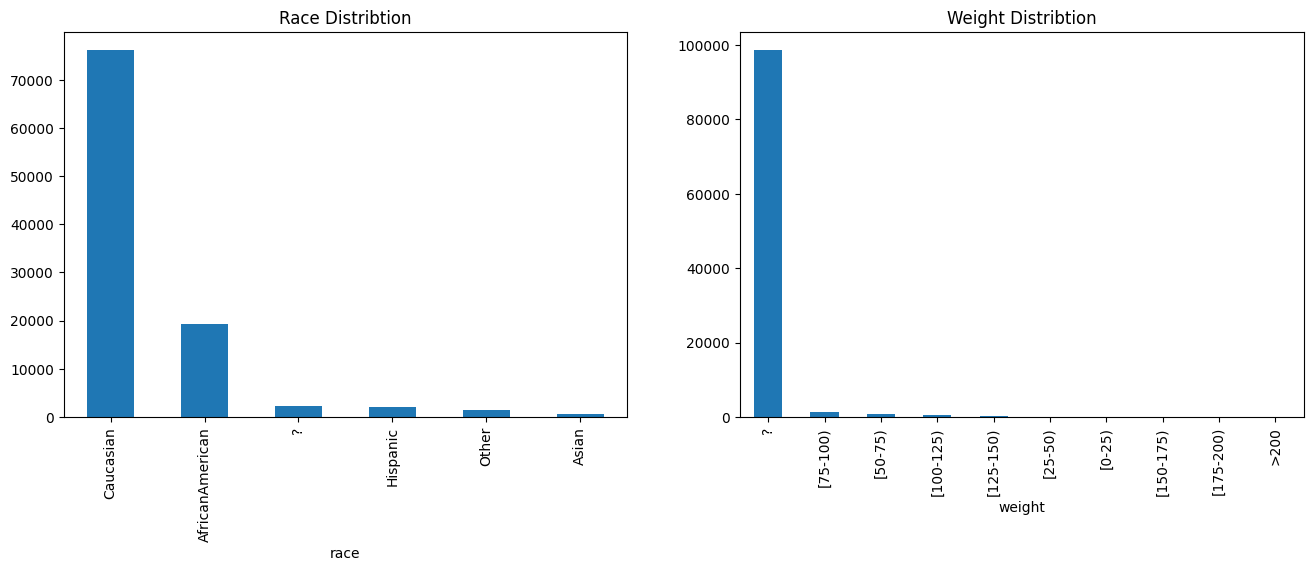

In [9]:
# Age counts and gender counts
age_count=original_data["age"].value_counts()
gender_count=original_data["gender"].value_counts()
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(16,5))
_ = age_count.plot(kind='bar',title='Age Distribtion',ax=ax1)
_ = gender_count.plot(kind='bar',title='Gender Distribtion',ax=ax2)

# Race counts and gender counts
race_count=original_data["race"].value_counts()
weight_count=original_data["weight"].value_counts()
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(16,5))
_ = race_count.plot(kind='bar',title='Race Distribtion',ax=ax1)
_ = weight_count.plot(kind='bar',title='Weight Distribtion',ax=ax2)

##### Original dataset will be saved, we're now cleaning the data to remove irrelevant columns and entries with crucial missing values

In [10]:
train = original_data.copy(deep=True)

In [11]:
missing_data = []

for col in train.columns:
    if train[col].dtype == 'object':  
        count_missing = (train[col] == '?').sum()  
        percent_missing = round((count_missing / train.shape[0]) * 100, 2)  
        if (percent_missing > 0.00):
            missing_data.append({"col": col, "count_missing": count_missing, "percent_missing": percent_missing})

missing_value = pd.DataFrame(missing_data).sort_values(by="percent_missing", ascending=False)
display(missing_value)

,col,count_missing,percent_missing
1,weight,98569,96.86
3,medical_specialty,49949,49.08
2,payer_code,40256,39.56
0,race,2273,2.23
6,diag_3,1423,1.40
5,diag_2,358,0.35
4,diag_1,21,0.02


In [12]:
train=train.drop(['weight','medical_specialty','payer_code'],axis=1)
diagnosis_dropped_rows = train[(train['diag_1'] == '?') & (train['diag_2'] == '?') & (train['diag_3'] == '?')].index
train = train.drop(index=diagnosis_dropped_rows)
train = train.drop(set(train[train['discharge_disposition_id']==11].index))
train.shape

(100123, 47)

In [15]:
#dropping missing values for gender and race
train = train.drop(set(train['gender'][train['gender'] == 'Unknown/Invalid'].index))
train= train.drop(set(train['race'][train['race']=='?'].index)) # drop the 2273 missing values
#dropping irrelevant columns
train=train.drop(["encounter_id","patient_nbr"],axis=1)
train=train.drop(["citoglipton","examide"],axis = 1)
train.shape

(97883, 43)

#### Adding New Features

In [ ]:
# Creating Med_change feature
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
        'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    col_name = str(col) + 'new' #change the column name
    train[col_name] = train[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)# recode the med use into binary variable
train['med_change'] = 0
for col in keys:
    col_name = str(col) + 'new'
    train['med_change'] = train['med_change'] + train[col_name]
    del train[col_name]

train['med_change'].value_counts()

med_change
0    71177
1    25307
2     1288
3      106
4        5
Name: count, dtype: int64

In [ ]:
#creating num_med feature
for col in keys:
    train[col] = train[col].replace('No', 0)
    train[col] = train[col].replace('Steady', 1)
    train[col] = train[col].replace('Up', 1)
    train[col] = train[col].replace('Down', 1)
train['num_med'] = 0
for col in keys:
    train['num_med'] = train['num_med'] + train[col]

train['num_med'].value_counts()

In [ ]:
# duplicate a diagnosis column
train['primary_diag'] = train['diag_1']
train['secondary_diag'] = train['diag_2']
train['additional_diag'] = train['diag_3']